## Deep Learning Dropout Uncertainty

This notebook introduces dropout uncertainty into the neural network by implementing the Monte Carlo Dropout.

In [1]:
#importing necessary packages
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Input
import pandas as pd
import numpy as np
import random
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.backend import clear_session
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.backend import clear_session
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#removing the seed for the cross validation and tensorflow so that each trained neural network produces slightly different results
cross_validation = KFold(n_splits = 3, shuffle = True, random_state = 10)

seed = 14
tf.random.set_seed(14)

In [3]:
#checking if GPU is being used 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11112664836862617515
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15513944064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5496216633422182882
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [4]:
#read dataframe from the Data Preparation Notebook 
df_complete3 = pd.read_pickle('df_complete3_v3.pickle')

In [5]:
#change types of the whole dataframe so that we do not run out of memory during the training process 
df_complete3 = df_complete3.astype(np.uint8)

In [6]:
#split off target column
target_column = df_complete3['number of conflicts']
df_complete3.drop(columns = ['number of conflicts'], inplace = True)

In [7]:
#perform train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_complete3, target_column, test_size = 0.08, random_state = 0)


In [8]:
#normalize the data with a StandardScaler - performance regarding simple model is better, so we continue with the Standard Scaler!
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [9]:
#change the dropout setting through the class
class MontheCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training = False)

In [10]:
clear_session()
model = Sequential()
del model
model = Sequential()

model.add(Dense(40, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(4)))
model.add(Dropout(0.0))
model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(50, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(30, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
model.add(Dropout(0.05))
model.add(Dense(1, kernel_initializer='normal', activation='relu'))

# Compile model
model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mean_squared_error'])

model.fit(X_train, y_train, epochs = 50, batch_size = 2000)

Epoch 1/50
47/47 [==============================] - 2s 11ms/step - loss: 320.9381 - mean_squared_error: 320.9381
Epoch 2/50
47/47 [==============================] - 1s 11ms/step - loss: 291.7386 - mean_squared_error: 291.7386
Epoch 3/50
47/47 [==============================] - 1s 11ms/step - loss: 260.8683 - mean_squared_error: 260.8683
Epoch 4/50
47/47 [==============================] - 1s 11ms/step - loss: 231.1536 - mean_squared_error: 231.1536
Epoch 5/50
47/47 [==============================] - 1s 11ms/step - loss: 197.4563 - mean_squared_error: 197.4563
Epoch 6/50
47/47 [==============================] - 1s 12ms/step - loss: 197.2903 - mean_squared_error: 197.2903
Epoch 7/50
47/47 [==============================] - 1s 12ms/step - loss: 180.7682 - mean_squared_error: 180.7682
Epoch 8/50
47/47 [==============================] - 1s 12ms/step - loss: 169.9673 - mean_squared_error: 169.9673
Epoch 9/50
47/47 [==============================] - 1s 11ms/step - loss: 229.1109 - mean_squared

In [11]:
#make predictions on the train and test set with the trained neural netowrk
y_pred_test_original = model.predict(X_test)
y_pred_train_original = model.predict(X_train)

In [12]:
#save the original prediction without dropout at test time 
y_pred_test_original = y_pred_test_original.copy()
y_pred_train_original = y_pred_train_original.copy()

Now the MonteCarlo Dropout technique is applied. 

In [51]:
#now rerun the training with training = TRUE
class MontheCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training = True)

In [52]:
#apply dropout also at test time in order to get many predictions!
#with this, we can analyze the distribution or get the average
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

In [53]:
#100 predictions per sample, plot distribution and a point estimate
y_pred_test_dist = predict_dist(X_test, model, 1000)
y_pred_test = predict_point(X_test, model, 1000)

In [22]:
y_pred_dist_train = predict_dist(X_train, model, 1000)
y_pred_train = predict_point(X_train, model, 1000)

C:\Users\Shadow\AppData\Local\Temp\ipykernel_23492\4011452436.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_test_dist[5], shade=True, color = "lightgreen", label = "distribution of predictions")


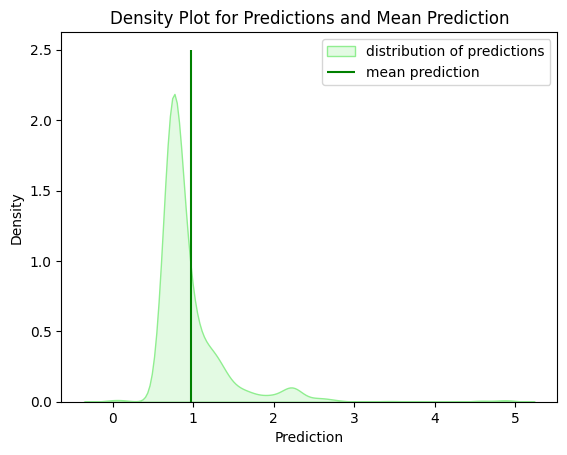

In [70]:
#visualize one distribution and the average value for the prediction
sns.kdeplot(y_pred_test_dist[5], shade=True, color = "lightgreen", label = "distribution of predictions")
plt.vlines(y_pred_test[5], 0, 2.5, color='green', label = "mean prediction")
plt.legend(loc = "upper right")
plt.title("Density Plot for Predictions and Mean Prediction")
plt.xlabel("Prediction")
plt.show()

In [ ]:
#https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571

In [23]:
#calculate error measures 
MSE = mean_squared_error(y_test , y_pred_test)
MAE = mean_absolute_error(y_test, y_pred_test)
print('Monte Carlo Dropout test MAE = ', MAE)
print('Monte Carlo Dropout test MSE = ', MSE)

MSE = mean_squared_error(y_test , y_pred_test_original)
MAE = mean_absolute_error(y_test, y_pred_test_original)
print('Original Model test MAE = ', MAE)
print('Original Model test MSE = ', MSE)

Monte Carlo Dropout test MAE =  3.4389741
Monte Carlo Dropout test MSE =  110.988945
Original Model test MAE =  3.3535175
Original Model test MSE =  110.94073


Monte Carlo Dropout test MAE =  3.4389741
Monte Carlo Dropout test MSE =  110.988945
Original Model test MAE =  3.3535175
Original Model test MSE =  110.94073

In [24]:
MSE = mean_squared_error(y_train , y_pred_train)
MAE = mean_absolute_error(y_train, y_pred_train)
print('Monte Carlo Dropout train MAE = ', MAE)
print('Monte Carlo Dropout train MSE = ', MSE)

MSE = mean_squared_error(y_train , y_pred_train_original)
MAE = mean_absolute_error(y_train, y_pred_train_original)
print('Original Model train MAE = ', MAE)
print('Original Model train MSE = ', MSE)


Monte Carlo Dropout train MAE =  3.450577
Monte Carlo Dropout train MSE =  121.6971
Original Model train MAE =  3.364123
Original Model train MSE =  121.51235


Monte Carlo Dropout train MAE =  3.450577
Monte Carlo Dropout train MSE =  121.6971
Original Model train MAE =  3.364123
Original Model train MSE =  121.51235

Taking the mean of the distribution, does not improve the model but it builds a distribution around it which can help to assess the uncertainty. 